In [1]:
import spacy
import pandas as pd
import random

C:\Users\tlp\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Data

In [34]:
df = pd.read_csv(r'data_cleaned/initial_corpus.csv')

print(df.shape)
df.head()

(8918, 8)


,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde


### Liste des pays

In [86]:
import pandas as pd

# Liste des pays avec leur nationalité, capitale et continent
pays_nationalite = [
    ("Afghanistan", "Afghan", "Kaboul", "Asie"),
    ("Afrique du Sud", "Sud-africain", "Pretoria", "Afrique"),
    ("Albanie", "Albanais", "Tirana", "Europe"),
    ("Algérie", "Algérien", "Alger", "Afrique"),
    ("Allemagne", "Allemand", "Berlin", "Europe"),
    ("Andorre", "Andorran", "Andorre-la-Vieille", "Europe"),
    ("Angola", "Angolais", "Luanda", "Afrique"),
    ("Antigua-et-Barbuda", "Antiguais", "Saint John's", "Amérique du Nord"),
    ("Arabie saoudite", "Saoudien", "Riyad", "Asie"),
    ("Argentine", "Argentin", "Buenos Aires", "Amérique du Sud"),
    ("Arménie", "Arménien", "Erevan", "Europe"),
    ("Australie", "Australien", "Canberra", "Océanie"),
    ("Autriche", "Autrichien", "Vienne", "Europe"),
    ("Azerbaïdjan", "Azéri", "Bakou", "Europe"),
    # Continuer la liste avec les autres pays et leurs informations
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique"),
    ("Égypte", "Égyptien", "Le Caire", "Afrique"),
    ("Émirats arabes unis", "Émirien", "Abou Dabi", "Asie"),
    ("Équateur", "Équatorien", "Quito", "Amérique du Sud"),
    ("Érythrée", "Érythréen", "Asmara", "Afrique"),
    ("Espagne", "Espagnol", "Madrid", "Europe"),
    ("Estonie", "Estonien", "Tallinn", "Europe"),
    ("États-Unis", "Américain", "Washington", "Amérique du Nord"),
    ("Éthiopie", "Éthiopien", "Addis-Abeba", "Afrique"),
    ("Fidji", "Fidjien", "Suva", "Océanie"),
    ("Finlande", "Finlandais", "Helsinki", "Europe"),
    ("France", "Français", "Paris", "Europe"),
    ("Gabon", "Gabonais", "Libreville", "Afrique"),
    ("Gambie", "Gambien", "Banjul", "Afrique"),
    ("Géorgie", "Géorgien", "Tbilissi", "Europe"),
    ("Ghana", "Ghanéen", "Accra", "Afrique"),
    ("Grèce", "Grec", "Athènes", "Europe"),
    ("Grenade", "Grenadien", "Saint-Georges", "Amérique du Nord"),
    ("Guatemala", "Guatémaltèque", "Guatemala", "Amérique du Nord"),
    ("Guinée", "Guinéen", "Conakry", "Afrique"),
    ("Guinée-Bissau", "Bissau-Guinéen", "Bissau", "Afrique"),
    ("Guinée équatoriale", "Équatoguinéen", "Malabo", "Afrique"),
    ("Guyana", "Guyanais", "Georgetown", "Amérique du Sud"),
    ("Haïti", "Haïtien", "Port-au-Prince", "Amérique du Nord"),
    ("Honduras", "Hondurien", "Tegucigalpa", "Amérique du Nord"),
    ("Hongrie", "Hongrois", "Budapest", "Europe"),
    ("Îles Marshall", "Marshallais", "Majuro", "Océanie"),
    ("Inde", "Indien", "New Delhi", "Asie"),
    ("Indonésie", "Indonésien", "Jakarta", "Asie"),
    ("Irak", "Irakien", "Bagdad", "Asie"),
    ("Iran", "Iranien", "Téhéran", "Asie"),
    ("Irlande", "Irlandais", "Dublin", "Europe"),
    ("Islande", "Islandais", "Reykjavik", "Europe"),
    ("Israël", "Israélien", "Jérusalem", "Asie"),
    ("Italie", "Italien", "Rome", "Europe"),
    ("Jamaïque", "Jamaïcain", "Kingston", "Amérique du Nord"),
    ("Japon", "Japonais", "Tokyo", "Asie"),
    ("Jordanie", "Jordanien", "Amman", "Asie"),
    ("Kazakhstan", "Kazakh", "Noursoultan", "Asie"),
    ("Kenya", "Kényan", "Nairobi", "Afrique"),
    ("Kirghizistan", "Kirghize", "Bichkek", "Asie"),
    ("Kiribati", "Kiribatien", "Tarawa", "Océanie"),
    ("Koweït", "Koweïtien", "Koweït", "Asie"),
    ("Laos", "Laotien", "Vientiane", "Asie"),
    ("Lesotho", "Lesothan", "Maseru", "Afrique"),
    ("Lettonie", "Letton", "Riga", "Europe"),
    ("Liban", "Libanais", "Beyrouth", "Asie"),
    ("Libéria", "Libérien", "Monrovia", "Afrique"),
    ("Libye", "Libyen", "Tripoli", "Afrique"),
    ("Liechtenstein", "Liechtensteinois", "Vaduz", "Europe"),
    ("Lituanie", "Lituanien", "Vilnius", "Europe"),
    ("Luxembourg", "Luxembourgeois", "Luxembourg", "Europe"),
    ("Macédoine du Nord", "Macédonien", "Skopje", "Europe"),
    ("Madagascar", "Malgache", "Antananarivo", "Afrique"),
    ("Malaisie", "Malaisien", "Kuala Lumpur", "Asie"),
    ("Malawi", "Malawien", "Lilongwe", "Afrique"),
    ("Maldives", "Maldivien", "Malé", "Asie"),
    ("Mali", "Malien", "Bamako", "Afrique"),
    ("Malte", "Maltais", "La Valette", "Europe"),
    ("Maroc", "Marocain", "Rabat", "Afrique"),
    ("Maurice", "Mauricien", "Port-Louis", "Afrique"),
    ("Mauritanie", "Mauritanien", "Nouakchott", "Afrique"),
    ("Mexique", "Mexicain", "Mexico", "Amérique du Nord"),
    ("Micronésie", "Micronésien", "Palikir", "Océanie"),
    ("Moldavie", "Moldave", "Chisinau", "Europe"),
    ("Monaco", "Monégasque", "Monaco", "Europe"),
    ("Mongolie", "Mongol", "Oulan-Bator", "Asie"),
    ("Monténégro", "Monténégrin", "Podgorica", "Europe"),
    ("Mozambique", "Mozambicain", "Maputo", "Afrique"),
    ("Namibie", "Namibien", "Windhoek", "Afrique"),
    ("Nauru", "Nauruan", "Yaren", "Océanie"),
    ("Népal", "Népalais", "Katmandou", "Asie"),
    ("Nicaragua", "Nicaraguayen", "Managua", "Amérique du Nord"),
    ("Niger", "Nigérien", "Niamey", "Afrique"),
    ("Nigeria", "Nigérian", "Abuja", "Afrique"),
    ("Niue", "Niuéen", "Alofi", "Océanie"),
    ("Norvège", "Norvégien", "Oslo", "Europe"),
    ("Nouvelle-Zélande", "Néo-zélandais", "Wellington", "Océanie"),
    ("Oman", "Omanais", "Mascate", "Asie"),
    ("Ouganda", "Ougandais", "Kampala", "Afrique"),
    ("Ouzbékistan", "Ouzbek", "Tachkent", "Asie"),
    ("Pakistan", "Pakistanais", "Islamabad", "Asie"),
    ("Palaos", "Palauan", "Ngerulmud", "Océanie"),
    ("Panama", "Panaméen", "Panama", "Amérique du Nord"),
    ("Papouasie-Nouvelle-Guinée", "Papouan-Néo-Guinéen", "Port Moresby", "Océanie"),
    ("Paraguay", "Paraguayen", "Asunción", "Amérique du Sud"),
    ("Pays-Bas", "Néerlandais", "Amsterdam", "Europe"),
    ("Pérou", "Péruvien", "Lima", "Amérique du Sud"),
    ("Philippines", "Philippin", "Manille", "Asie"),
    ("Pologne", "Polonais", "Varsovie", "Europe"),
    ("Portugal", "Portugais", "Lisbonne", "Europe"),
    ("Qatar", "Qatarien", "Doha", "Asie"),
    ("République centrafricaine", "Centrafricain", "Bangui", "Afrique"),
    ("République démocratique du Congo", "Congolais", "Kinshasa", "Afrique"),
    ("République dominicaine", "Dominicain", "Saint-Domingue", "Amérique du Nord"),
    ("République tchèque", "Tchèque", "Prague", "Europe"),
    ("Roumanie", "Roumain", "Bucarest", "Europe"),
    ("Royaume-Uni", "Britannique", "Londres", "Europe"),
    ("Russie", "Russe", "Moscou", "Europe"),
    ("Rwanda", "Rwandais", "Kigali", "Afrique"),
    ("Saint-Christophe-et-Niévès", "Saint-Christophien et Névicien", "Basseterre", "Amérique du Nord"),
    ("Saint-Marin", "Saint-Marinais", "Saint-Marin", "Europe"),
    ("Saint-Vincent-et-les-Grenadines", "Saint-Vincentais et Grenadin", "Kingstown", "Amérique du Nord"),
    ("Sainte-Lucie", "Saint-Lucien", "Castries", "Amérique du Nord"),
    ("Salomon", "Salomonais", "Honiara", "Océanie"),
    ("Salvador", "Salvadorien", "San Salvador", "Amérique du Nord"),
    ("Samoa", "Samoan", "Apia", "Océanie"),
    ("São Tomé-et-Príncipe", "Santoméen", "São Tomé", "Afrique"),
    ("Sénégal", "Sénégalais", "Dakar", "Afrique"),
    ("Serbie", "Serbe", "Belgrade", "Europe"),
    ("Seychelles", "Seychellois", "Victoria", "Afrique"),
    ("Sierra Leone", "Sierra-léonais", "Freetown", "Afrique"),
    ("Singapour", "Singapourien", "Singapour", "Asie"),
    ("Slovaquie", "Slovaque", "Bratislava", "Europe"),
    ("Slovénie", "Slovène", "Ljubljana", "Europe"),
    ("Somalie", "Somalien", "Mogadiscio", "Afrique"),
    ("Soudan", "Soudanais", "Khartoum", "Afrique"),
    ("Soudan du Sud", "Sud-Soudanais", "Djouba", "Afrique"),
    ("Sri Lanka", "Sri-lankais", "Sri Jayawardenapura Kotte", "Asie"),
    ("Suède", "Suédois", "Stockholm", "Europe"),
    ("Suisse", "Suisse", "Berne", "Europe"),
    ("Suriname", "Surinamien", "Paramaribo", "Amérique du Sud"),
    ("Syrie", "Syrien", "Damas", "Asie"),
    ("Swaziland", "Swazilandais", "Mbabane", "Afrique"),
    ("Tadjikistan", "Tadjik", "Douchanbé", "Asie"),
    ("Tanzanie", "Tanzanien", "Dodoma", "Afrique"),
    ("Tchad", "Tchadien", "N'Djaména", "Afrique"),
    ("Thaïlande", "Thaïlandais", "Bangkok", "Asie"),
    ("Timor oriental", "Est-timorais", "Dili", "Asie"),
    ("Togo", "Togolais", "Lomé", "Afrique"),
    ("Tonga", "Tongan", "Nuku'alofa", "Océanie"),
    ("Trinité-et-Tobago", "Trinidadien", "Port-d'Espagne", "Amérique du Nord"),
    ("Tunisie", "Tunisien", "Tunis", "Afrique"),
    ("Turkménistan", "Turkmène", "Achgabat", "Asie"),
    ("Turquie", "Turc", "Ankara", "Europe"),
    ("Tuvalu", "Tuvaluan", "Funafuti", "Océanie"),
    ("Ukraine", "Ukrainien", "Kiev", "Europe"),
    ("Uruguay", "Uruguayen", "Montevideo", "Amérique du Sud"),
    ("Vanuatu", "Vanuatuan", "Port-Vila", "Océanie"),
    ("Vatican", "Vaticanais", "Vatican", "Europe"),
    ("Venezuela", "Vénézuélien", "Caracas", "Amérique du Sud"),
    ("Viêt Nam", "Vietnamien", "Hanoï", "Asie"),
    ("Yémen", "Yéménite", "Sanaa", "Asie"),
    ("Zambie", "Zambien", "Lusaka", "Afrique"),
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique")
]

# Créer le DataFrame
df_pays = pd.DataFrame(pays_nationalite, columns=["Pays", "Nationalité", "Capitale", "Continent"])

# Afficher le DataFrame
display(df_pays)


,Pays,Nationalité,Capitale,Continent
0,Afghanistan,Afghan,Kaboul,Asie
1,Afrique du Sud,Sud-africain,Pretoria,Afrique
2,Albanie,Albanais,Tirana,Europe
3,Algérie,Algérien,Alger,Afrique
4,Allemagne,Allemand,Berlin,Europe
...,...,...,...,...
154,Venezuela,Vénézuélien,Caracas,Amérique du Sud
155,Viêt Nam,Vietnamien,Hanoï,Asie
156,Yémen,Yéménite,Sanaa,Asie
157,Zambie,Zambien,Lusaka,Afrique


### Extraire les nationalités

In [19]:
data = pd.read_csv(r'data_cleaned/initial_corpus.csv')
data.head()

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde


In [20]:
# Liste des nationalités
nationalites = [
    "Afghan", "Sud-africain", "Albanais", "Algérien", "Allemand", "Andorran", "Angolais", "Antiguais",
    "Saoudien", "Argentin", "Arménien", "Australien", "Autrichien", "Azéri", "Zimbabwéen", "Égyptien",
    "Émirien", "Équatorien", "Érythréen", "Espagnol", "Estonien", "Américain", "Éthiopien", "Fidjien",
    "Finlandais", "Français", "Gabonais", "Gambien", "Géorgien", "Ghanéen", "Grec", "Grenadien",
    "Guatémaltèque", "Guinéen", "Bissau-Guinéen", "Équatoguinéen", "Guyanais", "Haïtien", "Hondurien",
    "Hongrois", "Marshallais", "Indien", "Indonésien", "Irakien", "Iranien", "Irlandais", "Islandais",
    "Israélien", "Italien", "Jamaïcain", "Japonais", "Jordanien", "Kazakh", "Kényan", "Kirghize",
    "Kiribatien", "Koweïtien", "Laotien", "Lesothan", "Letton", "Libanais", "Libérien", "Libyen",
    "Liechtensteinois", "Lituanien", "Luxembourgeois", "Macédonien", "Malgache", "Malaisien", "Malawien",
    "Maldivien", "Malien", "Maltais", "Marocain", "Mauricien", "Mauritanien", "Mexicain", "Micronésien",
    "Moldave", "Monégasque", "Mongol", "Monténégrin", "Mozambicain", "Namibien", "Nauruan", "Népalais",
    "Nicaraguayen", "Nigérien", "Nigérian", "Niuéen", "Norvégien", "Néo-zélandais", "Omanais", "Ougandais",
    "Ouzbek", "Pakistanais", "Palauan", "Panaméen", "Papouan-Néo-Guinéen", "Paraguayen", "Néerlandais",
    "Péruvien", "Philippin", "Polonais", "Portugais", "Qatarien", "Centrafricain", "Congolais", "Dominicain",
    "Tchèque", "Roumain", "Britannique", "Russe", "Rwandais", "Saint-Christophien et Névicien", "Saint-Marinais",
    "Saint-Vincentais et Grenadin", "Saint-Lucien", "Salomonais", "Salvadorien", "Samoan", "Santoméen",
    "Sénégalais", "Serbe", "Seychellois", "Sierra-léonais", "Singapourien", "Slovaque", "Slovène",
    "Somalien", "Soudanais", "Sud-Soudanais", "Sri-lankais", "Suédois", "Suisse", "Surinamien", "Syrien",
    "Swazilandais", "Tadjik", "Tanzanien", "Tchadien", "Thaïlandais", "Est-timorais", "Togolais", "Tongan",
    "Trinidadien", "Tunisien", "Turkmène", "Turc", "Tuvaluan", "Ukrainien", "Uruguayen", "Vanuatuan",
    "Vaticanais", "Vénézuélien", "Vietnamien", "Yéménite", "Zambien", "Zimbabwéen"
]

# Fonction pour générer les différentes formes de nationalités
def generer_formes(nationalite):
    masculin_singulier = nationalite
    masculin_pluriel = nationalite + "s"
    feminin_singulier = nationalite + "e"
    feminin_pluriel = nationalite + "es"
    return masculin_singulier, masculin_pluriel, feminin_singulier, feminin_pluriel

# Création des colonnes avec les différentes formes de nationalités
df_nationalites = pd.DataFrame(nationalites, columns=["Nationalité"])
df_nationalites["Masculin Singulier"], df_nationalites["Masculin Pluriel"], df_nationalites["Féminin Singulier"], df_nationalites["Féminin Pluriel"] = zip(*df_nationalites["Nationalité"].apply(generer_formes))

# Affichage du DataFrame
print(df_nationalites)


      Nationalité Masculin Singulier Masculin Pluriel Féminin Singulier  \
0          Afghan             Afghan          Afghans           Afghane   
1    Sud-africain       Sud-africain    Sud-africains     Sud-africaine   
2        Albanais           Albanais        Albanaiss         Albanaise   
3        Algérien           Algérien        Algériens         Algériene   
4        Allemand           Allemand        Allemands         Allemande   
..            ...                ...              ...               ...   
154   Vénézuélien        Vénézuélien     Vénézuéliens      Vénézuéliene   
155    Vietnamien         Vietnamien      Vietnamiens       Vietnamiene   
156      Yéménite           Yéménite        Yéménites         Yéménitee   
157       Zambien            Zambien         Zambiens          Zambiene   
158    Zimbabwéen         Zimbabwéen      Zimbabwéens       Zimbabwéene   

    Féminin Pluriel  
0          Afghanes  
1    Sud-africaines  
2        Albanaises  
3        Al

In [96]:
df_nationalites.to_csv('all_nationalities.csv')

In [21]:
nlp = spacy.load("fr_core_news_sm")

In [22]:
nationalities = pd.concat([df_nationalites[col].apply(lambda x : x.lower()) for col in df_nationalites.columns]).unique()
def replace_nationality_entities(text):
    doc = nlp(text)
    replaced_text = []
    replaced_words = []  # Nouvelle liste pour stocker les mots remplacés
    for token in doc:
        if token.ent_type_ == "LOC" or token.ent_type_ == "GPE" or str(token).lower() in nationalities:
            replaced_text.append("PAMPLEMOUSSE")
            replaced_words.append(token.text)  # Ajouter le mot remplacé à la liste
        else:
            replaced_text.append(token.text)
    return " ".join(replaced_text), replaced_words

In [23]:
from tqdm import tqdm

for journal in tqdm(df.CJournal.unique()):
    d = data.loc[data.CJournal == journal].copy()
    d[["texte_processed", "replaced_words"]] = d["Texte"].apply(lambda x: pd.Series(replace_nationality_entities(x)))
    
    display(d.head())
    d.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_'+journal+'.csv',sep=";", index=False)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"[française, États, l’, Macédoine, du, Nord, Ba..."
10,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"[l’, Chine, l’, région, de, Wuhan, l’, l’, Eur..."
11,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"[grec, turc, grecs, turc, turc, l', Europe, ru..."
12,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"[FIGAROVOX.-, italien, l’, Quelles, l’, l’, l’..."


 17%|█████████████▌                                                                   | 1/6 [14:21<1:11:48, 861.77s/it]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde,"PAMPLEMOUSSE , PAMPLEMOUSSE , PAMPLEMOUSSE et ...","[Londres, Berlin, Rome, Bruxelles, corresponda..."
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde,"Jeudi 26 mars , les PAMPLEMOUSSE doivent se ...","[Vingt-Sept, Europe, l’, Suède, l’, l’, sacro,..."
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde,Tribune . L’ PAMPLEMOUSSE est le pays qui enre...,"[Italie, Italiens, non-Italiens, Français, Ita..."
5,Le Monde (site web),Les sept infos non liées au coronavirus que vo...,2020-03-20,Le Monde,On ne peut pas vous reprocher de penser que le...,nde s’est arrêté de tourner à cause de l’épidé...,"véritable monde alternatif, serein et chaleur...",Monde,On ne peut pas vous reprocher de penser que le...,"[l’, britanniques, Bonn, Rhénanie-du-Nord, -, ..."
6,Le Monde,Géopolitique | chronique Nous sommes tous de...,2020-03-19,par Philippe Bernard,"Jusqu'à la crise du coronavirus, la liberté de...","anchir librement les frontières, de sillonner ...",our les malheureux jetés sur les routes de l'e...,Monde,"Jusqu' à la crise du coronavirus , la liberté ...","[français, indien, malien, l', Europe, la, Fra..."


 33%|███████████████████████████▋                                                       | 2/6 [27:24<54:20, 815.16s/it]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
8,Libération (site web),"Schengen, l'autre victime du coronavirus",2020-03-19,Boris Grésillon,"Bien que le Covid-19 se joue des frontières, l...",onde s'hérisse de barrières. Ce paradoxe souli...,résillon professeur de géographie à Aix-Marsei...,Libération,"Bien que le Covid-19 se joue des frontières , ...","[Tribune, Etats-Unis, Vingt-Sept, Italie, Slov..."
16,Libération (site web),Erdogan réclame plus de soutien de l'UE et de ...,2020-03-09,AFP,Le président turc Recep Tayyip Erdogan a récla...,lundi lors d'une visite à Bruxelles un soutien...,rs d'une conférence de presse conjointe avec l...,Libération,Le président PAMPLEMOUSSE Recep Tayyip Erdogan...,"[turc, Bruxelles, Syrie, turc, Union]"
22,Libération (site web),Crise des migrants : les Vingt-sept haussent l...,2020-03-05,Jean Quatremer,"Mercredi, les ministres de l'intérieur de l'Un...",", convoqués à Bruxelles ont rejeté le «chantag...",Grèce des moyens de surveillance et l'Union va...,Libération,"Mercredi , les ministres de l' intérieur de l'...","[Bruxelles, turc, Bruxelles, turc, Turquie, Un..."
27,Libération (site web),"Mobilisation après le 49.3, crise des migrant...",2020-03-02,LIBERATION,L'essentiel de l'actualité 49.3. Le gouvern...,nt ayant coupé court au débat parlementaire en...,ent tendu entre Nétanyahou et son rival Benny ...,Libération,L' essentiel de l' actualité 49.3 . Le gou...,"[Paris, République, Europe, Lesbos, grecs, mar..."
28,Libération,"«Dans le voyage, il y a désidentification»",2020-02-29,Recueilli par Guillaume Lecaplain Envoyé spéci...,O n boit un thé un peu trop infusé dans une cu...,ne beaucoup trop ensoleillée pour la saison. M...,xpérience d'un autre que je suis. C'est au mie...,Libération,O n boit un thé un peu trop infusé dans une cu...,"[algérien, Lesbos, Bayonne, Bayonne, Capes, Mé..."


 50%|█████████████████████████████████████████▌                                         | 3/6 [32:11<28:41, 573.98s/it]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
13,La Croix (site web),Crise migratoire?: bras de fer autour de la fr...,2020-03-11,Marie Verdier,Après la visite du président turc Recep Tayyip...,"dogan à Bruxelles, lundi 9 mars, Emmanuel Macr...",nement pour faire face à l'afflux migratoire e...,Croix,Après la visite du président PAMPLEMOUSSE Rece...,"[turc, Bruxelles, allemande, Ankara, Combien, ..."
18,La Croix (site web),Un projet européen pour accueillir 1 500 enfan...,2020-03-09,Pierre Cochez,Face aux conditions de vie précaires des migra...,"dans les îles grecques, l'Allemagne prend la ...",prévoyant que les migrants restent en Turquie...,Croix,Face aux conditions de vie précaires des migra...,"[Allemagne, allemand, Paris, Grèce, Allemagne,..."
70,La Croix (site web),Hongrie?: Viktor Orban champion de la natalité,2019-09-06,François d'Alançon,Analyse\n \n \n Le premier mi...,hongrois a invoqué la théorie complotiste d'e...,eurs parents ayant jugé préférable d'avoir des...,Croix,Analyse \n \n \n Le premier ...,"[hongrois, Budapest, hongrois, Brésil, États-U..."
78,La Croix (site web),"En février 2020, une rencontre inédite des évê...",2019-08-21,Mélinée Le Priol (avec Vatican News),"Pour la première fois, les évêques des pays du...",urtour méditerranéen vont se réunir du 18 au 2...,re et la perception qu'en a l'opinion publique...,Croix,"Pour la première fois , les évêques des pays d...","[Bari, Pouilles, Turquie, Espagne, Grèce, Liby..."
79,La Croix (site web),Crise des migrants ou crise de la solidarité??,2019-08-19,Florence Montreynaud,Tribune\n \n \n La France doi...,eillir dignement des réfugiés. C'est notre dev...,leur humanité. Bienvenue en France?! (1) D...,Croix,Tribune \n \n \n La France d...,"[France, Afghanistan, Syrie, Soudan, Banglades..."


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [35:27<14:09, 424.66s/it]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
15,"Les Echos, no. 23154",Erdogan à Bruxelles pour démêler la crise des...,2020-03-09,CATHERINE CHATIGNOUX,"Samedi, Recep Tayyip Erdogan semblait jouer l'...",almie. « Sur ordre du président [...] aucun...,Union européenne. II a jusqu'ici refusé les 50...,Echos,"Samedi , Recep Tayyip Erdogan semblait jouer l...","[mer, Egée, Turquie, Lesbos, Samos, grec, Grèc..."
17,Les Echos (site web),Migrants : l'Europe propose d'accueillir 1.500...,2020-03-09,LES ECHOS,Situation ultra-tendue en Grèce. Lescamps de r...,giés surpeuplés et les conditions de vie de pl...,"de sécurité, de stabilité dans la région et d...",Echos,Situation ultra-tendue en PAMPLEMOUSSE . Lesca...,"[Grèce, Europe, allemand, Allemagne, Grèce, Al..."
24,Les Echos (site web),BHL : « Cette société française me fait peur »,2020-03-05,DANIEL FORTIN; NICOLAS BARRE,"Vous avez entrepris, depuis quelques semaines,...",vous rendre sur plusieurs théâtres de conflit...,es crimes de la bande à Baader. Jürgen Haberma...,Echos,"Vous avez entrepris , depuis quelques semaines...","[Paris, -, Match, Nigeria, Kurdistan, syrien, ..."
29,"Les Echos, no. 23140",L'Union européenne renforce sa surveillance de...,2020-02-18,YVES BOURDILLON,L'Europe va renforcer sa lutte contre le trafi...,'armes en Libye. Le Conseil des ministres des ...,"pération Sophia, lancée en 2015 au plus fort d...",Echos,PAMPLEMOUSSE PAMPLEMOUSSE va renforcer sa lutt...,"[L', Europe, Libye, Libye, Turquie, Tripoli, E..."
35,Les Echos (site web),"A Paris, Anne Hidalgo lance sa campagne tambou...",2020-01-13,LAURENT THEVENIN,La machine est lancée. Candidate depuis ce wee...,nd à sa réélection comme maire de Paris en mar...,"ati, la candidate Les Républicains (17 %), Ben...",Echos,La machine est lancée . Candidate depuis ce we...,"[Paris, porte, de, la, Chapelle, Parisien, Par..."


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [40:11<06:13, 373.97s/it]

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
26,Le Parisien,"Syrie, un cauchemar sans fin Des milliers de ...",2020-03-03,NaN,Par Henri Vernet Il aura fallu que l'Europ...,ue l'Europe se retrouve à nouveau sous la pres...,"et Macron sur la frontière turque, un peu à l...",Parisien,Par Henri Vernet Il aura fallu que PAMPLE...,"[l', Europe, Syrie, région, d', Idlib, Françai..."
36,Le Parisien,Par Marie-Anne Gairaud Et aussi D'incidents en,2019-12-18,Marie-Anne Gairaud,Par Marie-Anne Gairaud Et aussi D'incident...,n incidence ? C'est peu dire que la mandatur...,inimise aujourd'hui cette crise : « Ils étaien...,Parisien,Par Marie-Anne Gairaud Et aussi D' incid...,"[Paris, Paris, la, Ville, La, Ville, La, Ville..."
52,Le Parisien (site web),Municipales à Paris : Danielle Simonnet veut a...,2019-10-24,Marie-Anne Gairaud et Nicolas Maviel,Le mouvement La France Insoumise l'a désignée ...,f de file mais elle est prête à renoncer à bri...,c une vraie urgence sociale et écologique à re...,Parisien,Le mouvement La France Insoumise l' a désignée...,"[Paris, Paris, Capitale, XXe, Paris, Paris, bâ..."
64,Le Parisien,"A la biennale, les portraits font bonne figure...",2019-09-11,NaN,Issy-les-Moulineaux Par Estelle Dautry Des...,otos réalisées par David Lynch - qui a été élè...,rtrait à l'oeuvre. « Il nous faut du wi-fi pou...,Parisien,PAMPLEMOUSSE Par Estelle Dautry Des phot...,"[Issy-les-Moulineaux, Beaux, -, arts, Sculptur..."
65,Le Parisien,"Nager pour ne pas couler « WELCOME », de Phil...",2019-09-10,S.T.,vvvv « WELCOME » 20 h 55 (1 h 50). de Ph...,"ppe Lioret, avec Vincent Lindon (photo), Firat...","héroïsme ordinaire. Tout, ici, sonne vrai. Jus...",Parisien,vvvv « WELCOME » 20 h 55 ( 1 h 50 ) . ...,"[France, Welcome, piscine, de, Calais, Manche,..."


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [42:19<00:00, 423.28s/it]


In [24]:
final = pd.concat([
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Figaro.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Monde.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Libération.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Croix.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Parisien.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Echos.csv',sep=";")
])

In [25]:
final.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";", index=False)

In [94]:
data[["Texte","texte_processed","replaced_words"]].to_excel('test_replace_v3.xlsx')

<ipython-input-94-c96f84ad0861>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  data[["Texte","texte_processed","replaced_words"]].to_excel('test_replace_v3.xlsx')


### Etude des mots retirés

In [13]:
from tqdm import tqdm
words = {}

for row in tqdm(final.replaced_words) :
    row_formated = row[1:-1].replace("'","").replace('"','').split(',')
    for word in row_formated :
        if word.lower() not in words.keys() :
            words[word.lower()] = 1
        else :
            words[word.lower()] += 1
words

100%|███████████████████████████████████████████████████████████████████████████| 3030/3030 [00:00<00:00, 14111.31it/s]


{'rome': 7,
 ' bergame': 4,
 ' russe': 440,
 ' italien': 363,
 ' de': 1210,
 ' russie': 813,
 ' chine': 313,
 ' l': 3766,
 ' italie': 1213,
 ' russes': 337,
 ' kremlin': 101,
 ' libye': 332,
 ' moscou': 266,
 ' état': 1609,
 ' rossiya': 1,
 ' 1': 2,
 ' europe': 5743,
 ' états-unis': 805,
 ' la': 2874,
 ' français': 1914,
 ' allemagne': 2770,
 ' autriche': 446,
 ' pays': 274,
 ' -': 2053,
 ' bas': 150,
 ' vingt-sept': 50,
 'française': 30,
 ' états': 839,
 ' l’': 1781,
 ' macédoine': 110,
 ' du': 529,
 ' nord': 315,
 ' balkans': 339,
 ' espagne': 372,
 ' france': 3791,
 ' membres': 172,
 ' bruxelles': 873,
 ' brexit': 455,
 ' qu’': 190,
 ' nul': 1,
 ' n’': 13,
 'l’': 23,
 ' région': 33,
 ' wuhan': 6,
 ' française': 624,
 ' allemands': 524,
 ' japon': 48,
 ' israël': 64,
 ' singapour': 9,
 ' corée': 53,
 ' sud': 172,
 ' italiens': 198,
 ' s’': 146,
 ' aggrave': 1,
 ' européens': 672,
 'grec': 20,
 ' turc': 477,
 ' grecs': 148,
 ' britannique': 414,
 ' megxit': 1,
 ' kaboul': 114,
 ' afgh

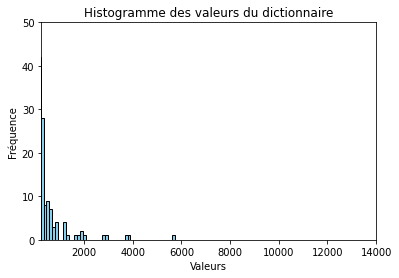

In [14]:
import matplotlib.pyplot as plt


# Extraire les valeurs du dictionnaire
values = list(words.values())

# Créer un histogramme
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.xlim(250, 14000)
plt.ylim(0, 50)
# Ajouter un titre et des labels aux axes
plt.title('Histogramme des valeurs du dictionnaire')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')

# Afficher l'histogramme
plt.show()

In [17]:
print([key for key in s if words[key] > 250])

[' union', ' biélorussie', ' moscou', ' britanniques', ' turcs', ' mays', ' pays', ' américaine', ' afghans', ' grec', ' etat', ' hongrois', ' polonais', ' grande-bretagne', ' irak', ' afghanistan', ' américains', ' république', ' chine', ' nord', ' suède', ' libye', ' russes', ' balkans', ' italien', ' espagne', ' ukraine', ' syrien', ' britannique', ' russe', ' autriche', ' brexit', ' turc', ' américain', ' ankara', ' méditerranée', ' royaume', ' uni', ' afrique', ' allemands', ' du', ' allemand', ' française', ' schengen', ' pologne', ' hongrie', ' européens', ' calais', ' syriens', ' allemande', ' berlin', ' états-unis', ' russie', ' états', ' bruxelles', ' paris', ' syrie', ' de', ' italie', ' grèce', ' état', ' l’', ' turquie', ' français', ' -', ' allemagne', ' la', ' l', ' france', ' europe']


In [16]:
s = sorted(words, key=words.get)
for w in s[len(s)-50:] :
    print(w)

 suède
 libye
 russes
 balkans
 italien
 espagne
 ukraine
 syrien
 britannique
 russe
 autriche
 brexit
 turc
 américain
 ankara
 méditerranée
 royaume
 uni
 afrique
 allemands
 du
 allemand
 française
 schengen
 pologne
 hongrie
 européens
 calais
 syriens
 allemande
 berlin
 états-unis
 russie
 états
 bruxelles
 paris
 syrie
 de
 italie
 grèce
 état
 l’
 turquie
 français
 -
 allemagne
 la
 l
 france
 europe


In [87]:
print(sorted(words.items(), key=lambda t: t[0]))

[('', 14), (' ', 7), ('  ', 113), ('   ', 68), ('    ', 19), ('     ', 10), ('       ', 5), ('        ', 1), (' !', 5), (' #', 2), (' &', 1), (' (', 1), (' )', 2), (' +', 3), (' -', 5262), (' -184', 1), (' -cancale', 1), (' -des', 1), (' -et', 1), (' -il', 4), (' -jérôme', 1), (' -libye', 2), (' -là', 1), (' -nord', 2), (' -pierre', 1), (' -thierry', 1), (' .', 1), (' .dans', 1), (' /', 2), (' 000personnes', 1), (' 08/03/16', 1), (' 1', 7), (' 10', 5), (' 101', 1), (' 11', 2), (' 12', 1), (' 15', 1), (' 15e', 2), (' 16', 1), (' 184personnes', 1), (' 18e', 4), (' 18h40', 1), (' 1er', 1), (' 2', 5), (' 200milliards', 1), (' 200personnes', 1), (' 2011.la', 1), (' 2012', 2), (' 2013', 1), (' 2014', 2), (' 2015', 6), (' 2015.mais', 1), (' 2015.un', 1), (' 2016', 1), (' 2017', 1), (' 2018', 1), (' 2018.le', 1), (' 215réfugiés', 1), (' 23rd', 1), (' 26', 3), (' 275euros', 1), (' 27e', 1), (' 2e', 1), (' 3-mai', 1), (' 300migrants', 1), (' 300milliards', 1), (' 350euros', 1), (' 36', 4), (' 40

### Constitution du gold standard

In [28]:
final = pd.read_csv(r'data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";")
final["annee"] = final.Date.apply(lambda date: date[:4])

In [37]:
df = final.copy()

# Calculer la distribution de chaque journal par année
distribution = df.groupby(['CJournal', 'annee']).size().reset_index(name='count')

# Calculer le nombre total d'articles par journal et année
total_articles = distribution['count'].sum()

# Déterminer combien d'articles doivent être sélectionnés de chaque journal chaque année
distribution['target_count'] = (distribution['count'] / total_articles * 300).round().astype(int)

# Initialiser une liste pour stocker les articles sélectionnés
gold_standard = []

# Sélectionner les articles
for index, row in distribution.iterrows():
    journal = row['CJournal']
    year = row['annee']
    target_count = row['target_count']
    
    # Filtrer les articles du journal et de l'année spécifiques
    filtered_df = df[(df['CJournal'] == journal) & (df['annee'] == year)]
    
    # Sélectionner aléatoirement les articles requis
    selected_articles = filtered_df.sample(n=target_count, random_state=42)
    
    # Ajouter les articles sélectionnés à la liste gold_standard
    gold_standard.append(selected_articles)

# Combiner les articles sélectionnés dans un nouveau DataFrame
gold_standard_df = pd.concat(gold_standard)

# Enregistrer le Gold Standard dans un nouveau fichier CSV si nécessaire
gold_standard_df.to_csv('data_cleaned/gold_standard.csv', index=False)


In [36]:
gold_standard_df.groupby(['CJournal', 'annee']).count()

Journal  Titre  Date  Auteur  Texte  extrait_debut  \
CJournal   annee                                                       
Croix      2015         4      4     4       4      4              4   
           2016         4      4     4       2      4              4   
           2017         2      2     2       0      2              2   
           2018         6      6     6       6      6              6   
           2019         3      3     3       3      3              3   
           2020         2      2     2       0      2              2   
           2021         2      2     2       0      2              2   
           2022         1      1     1       0      1              1   
Echos      2015        11     11    11      11     11             11   
           2016        14     14    14      14     14             14   
           2017         5      5     5       5      5              5   
           2018         6      6     6       6      6              6   
           2019         2      2     2       2      2              2   
           2020         1      1     1       0      1              1   
           2021         1      1     1       0      1              1   
           2022         1      1     1       0      1              1   
Figaro     2015        26     26    26      26     26             26   
           2016        28     28    28      26     28             28   
           2017        10     10    10       9     10             10   
           2018        16     16    16      16     16             16   
           2019         9      9     9       9      9              9   
           2020         5      5     5       2      5              5   
           2021         6      6     6       0      6              6   
           2022         2      2     2       0      2              2   
Libération 2015         5      5     5       4      5              5   
           2016         6      6     6       3      6              6   
           2017         3      3     3       2      3              3   
           2018         7      7     7       3      7              7   
           2019         4      4     4       2      4              4   
           2020         2      2     2       0      2              2   
           2021         2      2     2       0      2              2   
           2022         1      1     1       0      1              1   
Monde      2015        18     18    18       9     18             18   
           2016        23     23    23      10     23             23   
           2017        11     11    11       6     11             11   
           2018        10     10    10       5     10             10   
           2019         6      6     6       6      6              6   
           2020         3      3     3       1      3              3   
           2021         3      3     3       0      3              3   
           2022         1      1     1       0      1              1   
Parisien   2015         7      7     7       3      7              7   
           2016         5      5     5       2      5              5   
           2017         3      3     3       1      3              3   
           2018         3      3     3       2      3              3   
           2019         2      2     2       1      2              2   
           2020         1      1     1       0      1              1   
           2021         2      2     2       0      2              2   

                  extrait_fin  texte_processed  replaced_words  
CJournal   annee                                                
Croix      2015             4                4               4  
           2016             4                4               4  
           2017             2                2               2  
           2018             6                6               6  
           2019             3                3               3  
           2020             2     

In [40]:
len(gold_standard)

63

In [43]:
def replace(x):
    return replace_nationality_entities(x, df_pays.to_dict('records'))

data["texte_processed"] = data["Texte"].apply(replace)
data["replaced_words"] = data["Texte"].apply(lambda x: replace(x)[1])
data

<ipython-input-43-035997c6abfd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["texte_processed"] = data["Texte"].apply(replace)
<ipython-input-43-035997c6abfd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["replaced_words"] = data["Texte"].apply(lambda x: replace(x)[1])


,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,texte_processed,replaced_words
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,migrant_migratoire,(le symbol comptent parfois plus que le fait ....,"[europ, europ, europ, europ, allemagn, europ, ..."
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde,migrant_migratoire,"(PAMPLEMOUSSE , PAMPLEMOUSSE , PAMPLEMOUSSE et...","[europ, europ, europ, europ, europ, europ, eur..."
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,migrant_migratoire,(fin observ de la vi polit français et contrib...,"[alban, europ, europ, europ, alban, europ, all..."
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde,migrant_migratoire,"(jeud 26 mar , le vingt-sept doivent se réun e...","[europ, europ, europ, europ, europ, europ, eur..."
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde,migrant_migratoire,(tribun . l ’ PAMPLEMOUSSE est le pay qui enre...,"[europ, allemagn, allemand, berlin, franc, fra..."
...,...,...,...,...,...,...,...,...,...,...,...
95,Le Figaro.fr,Paris: une «maison des réfugiés» ouvre ses portes,2019-06-20,Le Figaro avec AFP,"Une «maison des réfugiés», financée par la Mai...",de Paris et centralisant initiatives et infor...,de Paris de se marquer comme une ville refuge...,Figaro,migrant_migratoire,"(une « maison de réfugi » , financ par la mair...","[paris, franc, paris, paris, franc, paris, paris]"
96,Libération (site web),Edition principale «La crise des migrants a ...,2019-06-20,Augustine Passilly,Le Haut-Commissariat de l'ONU pour les réfugié...,lerte sur un record de déplacements forcés. So...,es migrants vénézuéliens à la frontière péruvi...,Libération,migrant_migratoire,(le haut-commissariat de l'onu pour le réfugi ...,"[afghanistan, afriqu, afriqu, allemagn, keni, ..."
97,Le Monde.fr,Bac 2019 histoire-géo : le corrigé de la série S,2019-06-18,nan,"Après la philosophie, lundi 17 juin, les candi...",s au bac 2019 ont planché sur les épreuves d'h...,aciques et ponctuels; dans la troisième des fi...,Monde,migrant_migratoire,"(apres la philosoph , lund 17 juin , le candid...","[europ, europ, europ, europ, europ, allemagn, ..."
98,Le Figaro.fr,"Qu’est-ce que le MED 7, l’alliance des pays du...",2019-06-14,"Baldi, Gabriel","Le Med 7, qu’est-ce que c’est? Composé de sept...","ys du sud de l’Union européenne (France, Espag...",ccupation turque du nord de l’île ou encore la...,Figaro,migrant_migratoire,"(le med 7 , qu ’ est-ce que c ’ est ? compos d...","[europ, europ, europ, europ, europ, europ, eur..."


# NLP humanitaire vs securitaire

In [14]:
# Données annotées
gs = pd.read_csv('./data_cleaned/gold_standard_annote.csv')
gs.head()

,Journal,Titre,Date,Auteur,Texte,is_humanitaire,is_humanitaire_check,is_securitaire,is_securitaire_check,disagreement,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,annee
0,"La Croix, no. 40303",VU D'ITALIE Matteo Renzi veut un budget « en e...,2015-10-01,DANCER Marie,La saison budgétaire bat son plein en Europe. ...,0,0,0,0,NaN,me la France et les autres pays de la zone eur...,"ns le même temps, l'Italie réclame, comme l'Au...",Croix,La saison budgétaire bat son plein en PAMPLEMO...,"['Europe', 'la', 'France', ""l'"", 'Italie', 'Br...",2015
1,"La Croix, no. 40331","Ankara, partenaire incontournable des Européen...",2015-11-03,LE TALLEC Camille,BRUXELLES De notre correspondante Avec rés...,0,0,0,0,NaN,"e et sobriété, l'Union européenne a réagi aux ...","moment » , estimait de son côté le chef de l'...",Croix,BRUXELLES De notre correspondante Avec r...,"['Turquie', 'Bruxelles', 'Ankara', 'Turquie', ...",2015
2,"La Croix, no. 40327","Jeunes, réfugiés et vulnérables L'Autriche ve...",2015-10-29,VERDIER Marie,La longue route des migrants fluctue au gré de...,1,1,1,1,NaN,ermetures de frontière. À mesure que la Hongri...,semigratoire est susceptible de « provoquer u...,Croix,La longue route des migrants fluctue au gré de...,"['Hongrie', 'Serbie', 'Croatie', 'Grèce', 'Oue...",2015
3,"La Croix, no. 40341",Éditorial Ensemble,2015-11-16,GOUBERT Guillaume,"Depuis vendredi, la menace terroriste en Franc...",0,0,1,1,NaN,complètement changé de dimension. Ce que les s...,symbole serait que la France bénéficie de renf...,Croix,"Depuis vendredi , la menace terroriste en PAMP...","['France', 'La', 'France', 'Sahel', 'Proche', ...",2015
4,"La Croix, no. 40529",Entretien « Réduire la distance entre les élit...,2016-06-28,PLOQUIN Jean-Christophe,Qu'est-ce qui explique le malaise d'une partie...,0,0,1,1,NaN,s Européens vis-à-vis de la construction europ...,ui resterait ouverte à d'autres qui voudraient...,Croix,Qu' est -ce qui explique le malaise d' une par...,"['Européens', 'Portugal', 'Espagne', 'Italie',...",2016


In [24]:
display(gs[["CJournal","is_humanitaire","is_securitaire"]].groupby(["is_humanitaire","is_securitaire"]).count())
       
display(gs[["CJournal","Texte","is_humanitaire","is_securitaire"]].groupby(["CJournal","is_humanitaire","is_securitaire"]).count())

CJournal
is_humanitaire is_securitaire          
0              0                    100
               1                     84
1              0                     50
               1                     61

Texte
CJournal   is_humanitaire is_securitaire       
Croix      0              0                  10
                          1                   2
           1              0                   7
                          1                   5
Echos      0              0                  15
                          1                  12
           1              0                   4
                          1                  10
Figaro     0              0                  33
                          1                  37
           1              0                  16
                          1                  16
Libération 0              0                   9
                          1                   8
           1              0                   4
                          1                   9
Monde      0              0                  23
                          1                  20
           1              0                  13
                          1                  19
Parisien   0              0                  10
                          1                   5
           1              0                   6
                          1                   2

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

data = gs.copy()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data['Texte'], data[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

# Créer un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
vectorizer = CountVectorizer()

# Transformer les textes d'entraînement et de test
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Créer un classifieur bayésien pour la classification humanitaire
clf_humanitaire = MultinomialNB()
clf_humanitaire.fit(X_train_vect, y_train['is_humanitaire'])

# Créer un classifieur bayésien pour la classification sécuritaire
clf_securitaire = MultinomialNB()
clf_securitaire.fit(X_train_vect, y_train['is_securitaire'])

# Faire des prédictions sur l'ensemble de test pour chaque classifieur
y_pred_humanitaire = clf_humanitaire.predict(X_test_vect)
y_pred_securitaire = clf_securitaire.predict(X_test_vect)

# Analyser les résultats pour la classification humanitaire
print("Analyse des erreurs pour la classification humanitaire :")
print(classification_report(y_test['is_humanitaire'], y_pred_humanitaire))
print("Matrice de confusion pour humanitaire :")
print(confusion_matrix(y_test['is_humanitaire'], y_pred_humanitaire))

# Analyser les résultats pour la classification sécuritaire
print("\nAnalyse des erreurs pour la classification sécuritaire :")
print(classification_report(y_test['is_securitaire'], y_pred_securitaire))
print("Matrice de confusion pour sécuritaire :")
print(confusion_matrix(y_test['is_securitaire'], y_pred_securitaire))


Analyse des erreurs pour la classification humanitaire :
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.53      0.53      0.53        17

    accuracy                           0.73        59
   macro avg       0.67      0.67      0.67        59
weighted avg       0.73      0.73      0.73        59

Matrice de confusion pour humanitaire :
[[34  8]
 [ 8  9]]

Analyse des erreurs pour la classification sécuritaire :
              precision    recall  f1-score   support

           0       0.89      0.44      0.59        36
           1       0.51      0.91      0.66        23

    accuracy                           0.63        59
   macro avg       0.70      0.68      0.62        59
weighted avg       0.74      0.63      0.62        59

Matrice de confusion pour sécuritaire :
[[16 20]
 [ 2 21]]


In [29]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

data = gs.copy()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data['texte_processed'], data[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

# Créer un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
vectorizer = CountVectorizer()

# Transformer les textes d'entraînement et de test
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Créer un classifieur bayésien pour la classification humanitaire
clf_humanitaire = MultinomialNB()
clf_humanitaire.fit(X_train_vect, y_train['is_humanitaire'])

# Créer un classifieur bayésien pour la classification sécuritaire
clf_securitaire = MultinomialNB()
clf_securitaire.fit(X_train_vect, y_train['is_securitaire'])

# Faire des prédictions sur l'ensemble de test pour chaque classifieur
y_pred_humanitaire = clf_humanitaire.predict(X_test_vect)
y_pred_securitaire = clf_securitaire.predict(X_test_vect)

# Analyser les résultats pour la classification humanitaire
print("Analyse des erreurs pour la classification humanitaire :")
print(classification_report(y_test['is_humanitaire'], y_pred_humanitaire))
print("Matrice de confusion pour humanitaire :")
print(confusion_matrix(y_test['is_humanitaire'], y_pred_humanitaire))

# Analyser les résultats pour la classification sécuritaire
print("\nAnalyse des erreurs pour la classification sécuritaire :")
print(classification_report(y_test['is_securitaire'], y_pred_securitaire))
print("Matrice de confusion pour sécuritaire :")
print(confusion_matrix(y_test['is_securitaire'], y_pred_securitaire))


Analyse des erreurs pour la classification humanitaire :
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.53      0.59      0.56        17

    accuracy                           0.73        59
   macro avg       0.68      0.69      0.68        59
weighted avg       0.74      0.73      0.73        59

Matrice de confusion pour humanitaire :
[[33  9]
 [ 7 10]]

Analyse des erreurs pour la classification sécuritaire :
              precision    recall  f1-score   support

           0       0.88      0.39      0.54        36
           1       0.49      0.91      0.64        23

    accuracy                           0.59        59
   macro avg       0.68      0.65      0.59        59
weighted avg       0.72      0.59      0.58        59

Matrice de confusion pour sécuritaire :
[[14 22]
 [ 2 21]]


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Charger les données
data = gs.copy()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data['Texte'], data[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

# Créer un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
vectorizer = CountVectorizer()

# Transformer les textes d'entraînement et de test
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Définir une liste de classifieurs à tester
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Tester chaque classifieur pour is_humanitaire et is_securitaire
for name, clf in classifiers.items():
    print(f"\nRésultats pour le classifieur : {name}")

    # Classifieur pour is_humanitaire
    clf.fit(X_train_vect, y_train['is_humanitaire'])
    y_pred_humanitaire = clf.predict(X_test_vect)
    print("\nClassification humanitaire")
    print(classification_report(y_test['is_humanitaire'], y_pred_humanitaire))
    print("Matrice de confusion pour humanitaire :")
    print(confusion_matrix(y_test['is_humanitaire'], y_pred_humanitaire))

    # Classifieur pour is_securitaire
    clf.fit(X_train_vect, y_train['is_securitaire'])
    y_pred_securitaire = clf.predict(X_test_vect)
    print("\nClassification sécuritaire")
    print(classification_report(y_test['is_securitaire'], y_pred_securitaire))
    print("Matrice de confusion pour sécuritaire :")
    print(confusion_matrix(y_test['is_securitaire'], y_pred_securitaire))



Résultats pour le classifieur : Logistic Regression


C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification humanitaire
              precision    recall  f1-score   support

           0       0.76      0.83      0.80        42
           1       0.46      0.35      0.40        17

    accuracy                           0.69        59
   macro avg       0.61      0.59      0.60        59
weighted avg       0.67      0.69      0.68        59

Matrice de confusion pour humanitaire :
[[35  7]
 [11  6]]


C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Classification sécuritaire
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        36
           1       0.60      0.65      0.63        23

    accuracy                           0.69        59
   macro avg       0.68      0.69      0.68        59
weighted avg       0.70      0.69      0.70        59

Matrice de confusion pour sécuritaire :
[[26 10]
 [ 8 15]]

Résultats pour le classifieur : Linear SVM

Classification humanitaire
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        42
           1       0.47      0.41      0.44        17

    accuracy                           0.69        59
   macro avg       0.62      0.61      0.61        59
weighted avg       0.68      0.69      0.69        59

Matrice de confusion pour humanitaire :
[[34  8]
 [10  7]]

Classification sécuritaire
              precision    recall  f1-score   support

           0       0.78      0.69      0.74  

In [43]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Charger les données
data = gs.copy()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data['texte_processed'], data[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

# Créer un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
vectorizer = CountVectorizer()

# Transformer les textes d'entraînement et de test
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Définir une liste de classifieurs à tester
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Tester chaque classifieur pour is_humanitaire et is_securitaire
for name, clf in classifiers.items():
    print(f"\nRésultats pour le classifieur : {name}")

    # Classifieur pour is_humanitaire
    clf.fit(X_train_vect, y_train['is_humanitaire'])
    y_pred_humanitaire = clf.predict(X_test_vect)
    print("\nClassification humanitaire")
    print(classification_report(y_test['is_humanitaire'], y_pred_humanitaire))
    print("Matrice de confusion pour humanitaire :")
    print(confusion_matrix(y_test['is_humanitaire'], y_pred_humanitaire))

    # Classifieur pour is_securitaire
    clf.fit(X_train_vect, y_train['is_securitaire'])
    y_pred_securitaire = clf.predict(X_test_vect)
    print("\nClassification sécuritaire")
    print(classification_report(y_test['is_securitaire'], y_pred_securitaire))
    print("Matrice de confusion pour sécuritaire :")
    print(confusion_matrix(y_test['is_securitaire'], y_pred_securitaire))



Résultats pour le classifieur : Logistic Regression


C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification humanitaire
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.53      0.53      0.53        17

    accuracy                           0.73        59
   macro avg       0.67      0.67      0.67        59
weighted avg       0.73      0.73      0.73        59

Matrice de confusion pour humanitaire :
[[34  8]
 [ 8  9]]


C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Classification sécuritaire
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        36
           1       0.59      0.57      0.58        23

    accuracy                           0.68        59
   macro avg       0.66      0.66      0.66        59
weighted avg       0.68      0.68      0.68        59

Matrice de confusion pour sécuritaire :
[[27  9]
 [10 13]]

Résultats pour le classifieur : Linear SVM

Classification humanitaire
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        42
           1       0.53      0.47      0.50        17

    accuracy                           0.73        59
   macro avg       0.66      0.65      0.66        59
weighted avg       0.72      0.73      0.72        59

Matrice de confusion pour humanitaire :
[[35  7]
 [ 9  8]]

Classification sécuritaire
              precision    recall  f1-score   support

           0       0.75      0.75      0.75  

C:\Users\tlp\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Classification humanitaire
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        42
           1       1.00      0.29      0.45        17

    accuracy                           0.80        59
   macro avg       0.89      0.65      0.66        59
weighted avg       0.84      0.80      0.75        59

Matrice de confusion pour humanitaire :
[[42  0]
 [12  5]]

Classification sécuritaire
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        36
           1       0.56      0.61      0.58        23

    accuracy                           0.66        59
   macro avg       0.65      0.65      0.65        59
weighted avg       0.67      0.66      0.66        59

Matrice de confusion pour sécuritaire :
[[25 11]
 [ 9 14]]


In [37]:
df_cleaned = pd.read_csv('./data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";")
df_cleaned.head()

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"['Rome', 'Bergame', 'russe', 'italien', 'De', ..."
1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"['française', 'États', 'l’', 'Macédoine', 'du'..."
2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"['l’', 'Chine', 'l’', 'région', 'de', 'Wuhan',..."
3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"['grec', 'turc', 'grecs', 'turc', 'turc', ""l'""..."
4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"['FIGAROVOX.-', 'italien', 'l’', 'Quelles', 'l..."


In [41]:
clf_humanitaire = RandomForestClassifier(random_state=42)
clf_securitaire = RandomForestClassifier(random_state=42)

# Données d'entraiment issues du GS
X_train, X_test, y_train, y_test = train_test_split(data['texte_processed'], data[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

# Créer un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
vectorizer = CountVectorizer()

# Transformer les textes d'entraînement et de test
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Entraintement
clf_humanitaire.fit(X_train_vect, y_train['is_humanitaire'])
clf_securitaire.fit(X_train_vect, y_train['is_securitaire'])

# Application
print("Prediction is_humanitaire")
df_cleaned["is_humanitaire_pred"] = clf_humanitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Prediction is_securitaire")
df_cleaned["is_securitaire_pred"] = clf_securitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Done")

Prediction is_humanitaire
Prediction is_securitaire
Done


In [46]:
display(df_cleaned[["CJournal","is_humanitaire_pred","is_securitaire_pred"]].groupby(["is_humanitaire_pred","is_securitaire_pred"]).count())
       
display(df_cleaned[["CJournal","Texte","is_humanitaire_pred","is_securitaire_pred"]].groupby(["CJournal","is_humanitaire_pred","is_securitaire_pred"]).count())

CJournal
is_humanitaire_pred is_securitaire_pred          
0                   0                        4374
                    1                        2920
1                   0                         248
                    1                        1376

Texte
CJournal   is_humanitaire_pred is_securitaire_pred       
Croix      0                   0                      393
                               1                      200
           1                   0                       38
                               1                      166
Echos      0                   0                      738
                               1                      369
           1                   0                       30
                               1                      127
Figaro     0                   0                     1658
                               1                      949
           1                   0                       67
                               1                      356
Libération 0                   0                      374
                               1                      287
           1                   0                       25
                               1                      220
Monde      0                   0                      779
                               1                      984
           1                   0                       50
                               1                      419
Parisien   0                   0                      432
                               1                      131
           1                   0                       38
                               1                       88

Proportion d'articles classés comme humanitaires et sécuritaires :
Humanitaires : 18.21%
Sécuritaires : 48.17%

Analyse par journaux :
            is_humanitaire_pred  is_securitaire_pred
CJournal                                            
Croix                  0.255960             0.459222
Echos                  0.124209             0.392405
Figaro                 0.139604             0.430693
Libération             0.270419             0.559603
Monde                  0.210125             0.628584
Parisien               0.182874             0.317852

Analyse par années :
       is_humanitaire_pred  is_securitaire_pred
Année                                          
2009              0.333333             0.333333
2010              0.500000             0.500000
2011              0.250000             0.375000
2012              0.000000             1.000000
2013              0.200000             0.600000
2014              0.461538             0.769231
2015              0.180536         

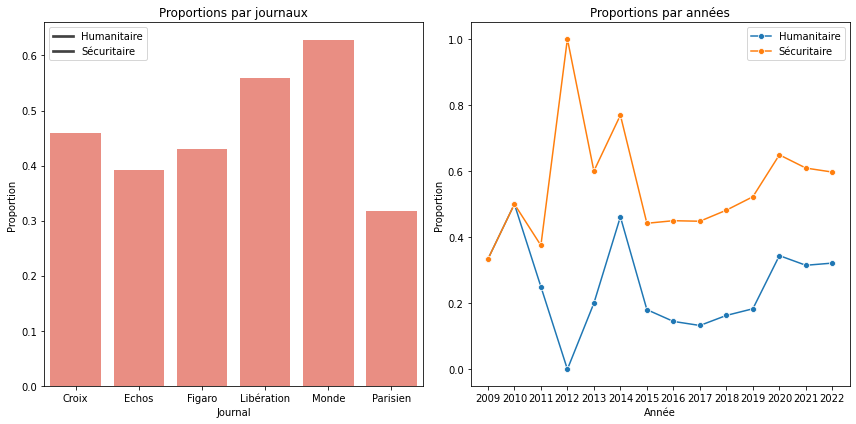

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analyser la proportion d'articles de chaque type
print("Proportion d'articles classés comme humanitaires et sécuritaires :")
prop_humanitaire = df_cleaned['is_humanitaire_pred'].mean()
prop_securitaire = df_cleaned['is_securitaire_pred'].mean()
print(f"Humanitaires : {prop_humanitaire * 100:.2f}%")
print(f"Sécuritaires : {prop_securitaire * 100:.2f}%")

# Segmentation par journaux
print("\nAnalyse par journaux :")
grouped_by_journal = df_cleaned.groupby('CJournal')
journal_analysis = grouped_by_journal.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
print(journal_analysis)

# Segmentation par années
print("\nAnalyse par années :")
df_cleaned["Année"] = df_cleaned["Date"].apply(lambda x: x[:4])
grouped_by_year = df_cleaned.groupby('Année')
year_analysis = grouped_by_year.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
print(year_analysis)

# Visualisation des proportions d'articles classés humanitaires et sécuritaires
plt.figure(figsize=(12, 6))

# Graphique à barres pour les journaux
plt.subplot(1, 2, 1)
sns.barplot(x=journal_analysis.index, y='is_humanitaire_pred', data=journal_analysis, color='skyblue')
sns.barplot(x=journal_analysis.index, y='is_securitaire_pred', data=journal_analysis, color='salmon')
plt.title("Proportions par journaux")
plt.xlabel("Journal")
plt.ylabel("Proportion")
plt.legend(["Humanitaire", "Sécuritaire"])

# Graphique à lignes pour les années
plt.subplot(1, 2, 2)
sns.lineplot(x=year_analysis.index, y='is_humanitaire_pred', data=year_analysis, label='Humanitaire', marker='o')
sns.lineplot(x=year_analysis.index, y='is_securitaire_pred', data=year_analysis, label='Sécuritaire', marker='o')
plt.title("Proportions par années")
plt.xlabel("Année")
plt.ylabel("Proportion")
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()


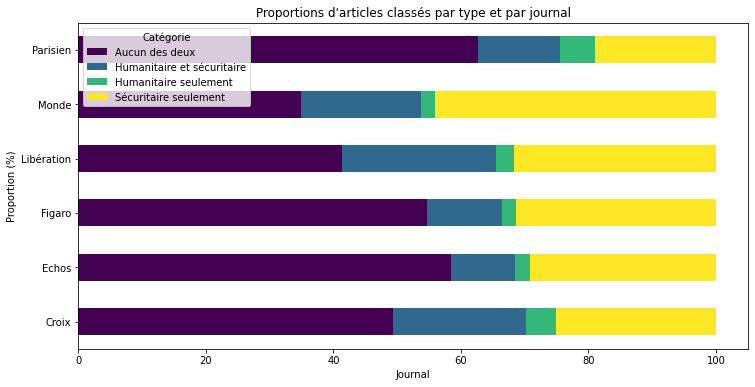

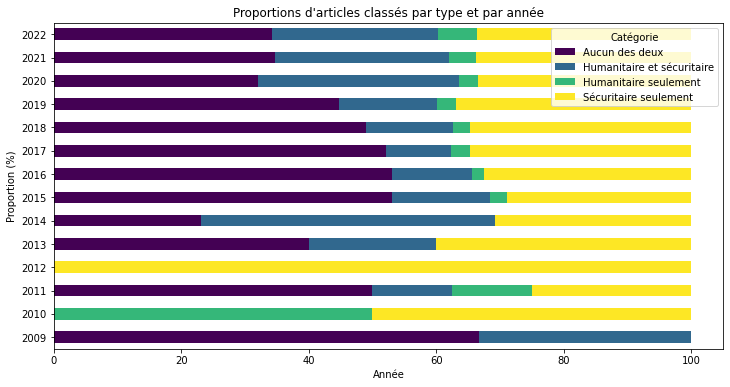

In [51]:

# Calcul des catégories
df_cleaned['category'] = (
    df_cleaned['is_humanitaire_pred'].astype(str) + '_' + df_cleaned['is_securitaire_pred'].astype(str)
)
# Convertir les catégories en descriptifs
df_cleaned['category'] = df_cleaned['category'].replace({
    '1_0': 'Humanitaire seulement',
    '0_1': 'Sécuritaire seulement',
    '1_1': 'Humanitaire et sécuritaire',
    '0_0': 'Aucun des deux'
})

# Segmentation par journaux
grouped_by_journal = df_cleaned.groupby(['CJournal', 'category']).size().unstack().fillna(0)

# Calcul des proportions pour chaque journal
proportions_by_journal = grouped_by_journal.div(grouped_by_journal.sum(axis=1), axis=0) * 100

# Créer un graphique à barres empilées à 100% pour les journaux
proportions_by_journal.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Proportions d'articles classés par type et par journal")
plt.xlabel("Journal")
plt.ylabel("Proportion (%)")
plt.legend(title="Catégorie")
plt.show()

# Segmentation par années
grouped_by_year = df_cleaned.groupby(['Année', 'category']).size().unstack().fillna(0)

# Calcul des proportions pour chaque année
proportions_by_year = grouped_by_year.div(grouped_by_year.sum(axis=1), axis=0) * 100

# Créer un graphique à barres empilées à 100% pour les années
proportions_by_year.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Proportions d'articles classés par type et par année")
plt.xlabel("Année")
plt.ylabel("Proportion (%)")
plt.legend(title="Catégorie")
plt.show()


Top mots par proportion pour chaque catégorie :
         CJournal                    category replaced_words  word_count  \
15683      Figaro       Sécuritaire seulement         Europe        2969   
6291        Echos  Humanitaire et sécuritaire         Europe         377   
30235       Monde       Sécuritaire seulement         Europe        2917   
34730    Parisien  Humanitaire et sécuritaire         Europe         250   
7540        Echos       Sécuritaire seulement         Europe        1040   
26880       Monde  Humanitaire et sécuritaire         Europe        1109   
12571      Figaro  Humanitaire et sécuritaire         Europe         939   
22424  Libération       Sécuritaire seulement         Europe         738   
3405        Croix       Sécuritaire seulement         Europe         490   
34803    Parisien  Humanitaire et sécuritaire        Hongrie         197   

       total_count  proportion  
15683          949    3.128556  
6291           127    2.968504  
30235          9

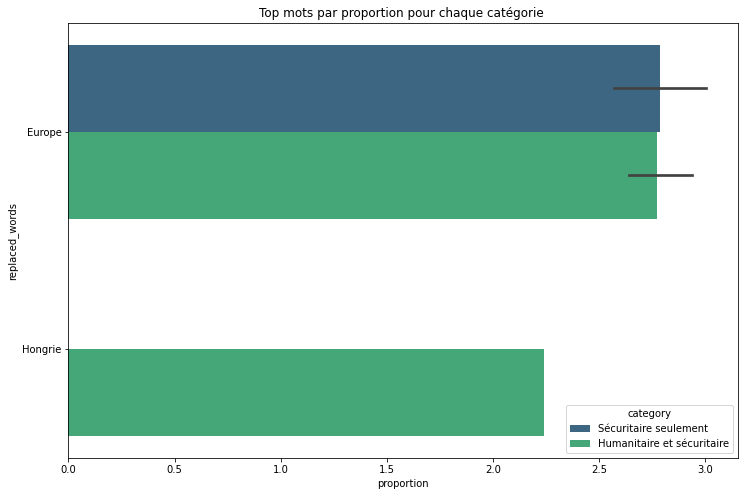

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_cleaned['replaced_words'] = df_cleaned.replaced_words.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Définir une liste de mots à ne pas renvoyer
exclude_words = ["word1", "word2", "word3"]  # Remplacez par les mots à exclure

# Fonction pour analyser les mots les plus présents dans chaque catégorie
def analyze_words(df, groupby_cols, title_suffix=''):
    # Calcul des statistiques pour chaque mot
    word_analysis = df.explode('replaced_words')  # Éclater la liste replaced_words en lignes individuelles
    word_analysis = word_analysis[~word_analysis['replaced_words'].isin(exclude_words)]  # Exclure les mots à ne pas renvoyer

    # Calculer le nombre d'articles contenant chaque mot par catégorie
    word_count_by_category = word_analysis.groupby(groupby_cols + ['replaced_words']).size().reset_index(name='word_count')
    
    # Calculer le nombre total d'articles par catégorie
    total_articles_by_category = df.groupby(groupby_cols).size().reset_index(name='total_count')
    
    # Fusionner les données pour calculer la proportion d'articles contenant chaque mot
    word_proportion_by_category = word_count_by_category.merge(total_articles_by_category, on=groupby_cols)
    word_proportion_by_category['proportion'] = word_proportion_by_category['word_count'] / word_proportion_by_category['total_count']
    
    # Trier les mots par proportion décroissante et affichage des résultats
    word_proportion_by_category = word_proportion_by_category.sort_values(by=['proportion'], ascending=False)
    
    print(f"Top mots par proportion pour chaque catégorie {title_suffix}:")
    print(word_proportion_by_category.head(10))
    
    # Visualisation des résultats
    plt.figure(figsize=(12, 8))
    sns.barplot(x='proportion', y='replaced_words', hue='category', data=word_proportion_by_category.head(10), palette='viridis')
    plt.title(f"Top mots par proportion pour chaque catégorie {title_suffix}")
    plt.show()
    
analyze_words(df_cleaned, ['CJournal', 'category'], title_suffix='')

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_cleaned['replaced_words'] = df_cleaned.replaced_words.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Définir une liste de mots à ne pas renvoyer
exclude_words = ["word1", "word2", "word3"]  # Remplacez par les mots à exclure

# Fonction pour analyser les mots les plus présents dans chaque catégorie
def analyze_words(df, groupby_cols, title_suffix=''):
    # Calcul des statistiques pour chaque mot
    word_analysis = df.explode('replaced_words')  # Éclater la liste replaced_words en lignes individuelles
    word_analysis = word_analysis[~word_analysis['replaced_words'].isin(exclude_words)]  # Exclure les mots à ne pas renvoyer

    # Calculer le nombre d'articles contenant chaque mot par catégorie
    word_count_by_category = word_analysis.groupby(groupby_cols + ['replaced_words']).size().reset_index(name='word_count')
    
    # Calculer le nombre total d'articles par catégorie
    total_articles_by_category = df.groupby(groupby_cols).size().reset_index(name='total_count')
    
    # Fusionner les données pour calculer la proportion d'articles contenant chaque mot
    word_proportion_by_category = word_count_by_category.merge(total_articles_by_category, on=groupby_cols)
    word_proportion_by_category['proportion'] = word_proportion_by_category['word_count'] / word_proportion_by_category['total_count']
    
    # Trier les mots par proportion décroissante et affichage des résultats
    word_proportion_by_category = word_proportion_by_category.sort_values(by=['proportion'], ascending=False)
    
    print(f"Top mots par proportion pour chaque catégorie {title_suffix}:")
    print(word_proportion_by_category.head(10))
    
    # Visualisation des résultats
    plt.figure(figsize=(12, 8))
    sns.barplot(x='proportion', y='replaced_words', hue='category', data=word_proportion_by_category.head(10), palette='viridis')
    plt.title(f"Top mots par proportion pour chaque catégorie {title_suffix}")
    plt.show()
    
analyze_words(df_cleaned, ['CJournal', 'category'], title_suffix='')

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,is_humanitaire_pred,is_securitaire_pred,Année,category,replace_words
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,Rome,0,0,2020,Aucun des deux,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,Bergame,0,0,2020,Aucun des deux,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,russe,0,0,2020,Aucun des deux,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,italien,0,0,2020,Aucun des deux,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,De,0,0,2020,Aucun des deux,"[Rome, Bergame, russe, italien, De, Russie, Ch..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,Les Echos,Crise migratoire aux Canaries : l'Europe doit...,2020-05-27,NaN,"La déception a été à la hauteur de l'espoir, i...","nse, il y a dix ans. Le 17 december2010, le su...",e n'ait été qu'une illustration de cette ligne...,Echos,"La déception a été à la hauteur de l' espoir ,...",Regardez,0,1,2020,Sécuritaire seulement,"[Tunis, Afrique, du, Nord, Moyen-Orient, Pouss..."
8917,Les Echos,Crise migratoire aux Canaries : l'Europe doit...,2020-05-27,NaN,"La déception a été à la hauteur de l'espoir, i...","nse, il y a dix ans. Le 17 december2010, le su...",e n'ait été qu'une illustration de cette ligne...,Echos,"La déception a été à la hauteur de l' espoir ,...",Algérie,0,1,2020,Sécuritaire seulement,"[Tunis, Afrique, du, Nord, Moyen-Orient, Pouss..."
8917,Les Echos,Crise migratoire aux Canaries : l'Europe doit...,2020-05-27,NaN,"La déception a été à la hauteur de l'espoir, i...","nse, il y a dix ans. Le 17 december2010, le su...",e n'ait été qu'une illustration de cette ligne...,Echos,"La déception a été à la hauteur de l' espoir ,...",Liban,0,1,2020,Sécuritaire seulement,"[Tunis, Afrique, du, Nord, Moyen-Orient, Pouss..."
8917,Les Echos,Crise migratoire aux Canaries : l'Europe doit...,2020-05-27,NaN,"La déception a été à la hauteur de l'espoir, i...","nse, il y a dix ans. Le 17 december2010, le su...",e n'ait été qu'une illustration de cette ligne...,Echos,"La déception a été à la hauteur de l' espoir ,...",Irak,0,1,2020,Sécuritaire seulement,"[Tunis, Afrique, du, Nord, Moyen-Orient, Pouss..."


In [121]:
from tqdm import tqdm

stat_figaro = pd.DataFrame()
stat_monde = pd.DataFrame()
stat_liberation = pd.DataFrame()
stat_croix = pd.DataFrame()
stat_parisien = pd.DataFrame()
stat_echos = pd.DataFrame()

stat = pd.DataFrame()

for journal, dataframe in [
    ["Figaro", stat_figaro],
    ["Monde", stat_monde],
    ["Libération", stat_liberation],
    ["Croix", stat_croix],
    ["Parisien", stat_parisien],
    ["Echos", stat_echos],
] :
    print(f"Traitement de {journal}")
    df = df_cleaned.loc[df_cleaned.CJournal==journal]
    
    for year in df["Année"].unique():
        print(year)
        data = df.loc[df["Année"]==year]
    
        dict_humanitaire = {}
        dict_securitaire = {}

        for replaced_words in np.array(data.loc[data["is_humanitaire_pred"]==1, "replaced_words"]) :
            for word in replaced_words :
                word = word.lower()
                if word not in dict_humanitaire.keys():
                    dict_humanitaire[word] = 1
                else :
                    dict_humanitaire[word] += 1

        for replaced_words in np.array(data.loc[data["is_securitaire_pred"]==1, "replaced_words"]) :
            for word in replaced_words :
                word = word.lower()
                if word not in dict_securitaire.keys():
                    dict_securitaire[word] = 1
                else :
                    dict_securitaire[word] += 1

        # Convertir les dictionnaires en dataframes
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'occurence_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'occurence_secu'])

        # Fusionner les deux dataframes sur la colonne 'Mot'
        result_df = pd.merge(df_huma, df_secu, on='mots', how='outer')

        ### Nombre d'articles
        print("Process nombre d'article")
        dict_humanitaire = {}
        dict_securitaire = {}

        for word in result_df.mots :            
            for replaced_words in data.loc[data["is_humanitaire_pred"]==1, "replaced_words"] :
                word = word.lower()
                if word in replaced_words :  
                    if word not in dict_humanitaire.keys():
                        dict_humanitaire[word] = 1
                    else :
                        dict_humanitaire[word] += 1

            for replaced_words in data.loc[data["is_securitaire_pred"]==1, "replaced_words"] :
                word = word.lower()
                if word in replaced_words : 
                    if word not in dict_securitaire.keys():
                        dict_securitaire[word] = 1
                    else :
                        dict_securitaire[word] += 1
        
        # Convertir les dictionnaires en dataframes
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'articles_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'articles_secu'])

        # Fusionner les deux dataframes sur la colonne 'Mot'
        result_df = pd.merge(result_df, df_huma, on='mots', how='left')
        result_df = pd.merge(result_df, df_secu, on='mots', how='left')

        # Remplacer les valeurs manquantes par 0
        result_df = result_df.fillna(0)
        result_df.insert(0,"journal",journal)
        result_df.insert(1,"annees",year)
        
        stat = pd.concat([
            stat,
            result_df
        ])
    
            

Traitement de Figaro
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Monde
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2012
Process nombre d'article
2010
Process nombre d'article
2009
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Libération
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011

In [127]:
stat.to_csv('./data_cleaned/stat_nat_huma_secu.csv')

In [92]:
from tqdm import tqdm

stat_figaro = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])
stat_monde = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])
stat_liberation = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])
stat_croix = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])
stat_parisien = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])
stat_echos = pd.DataFrame(columns=["mots","nb_occurence_huma","nb_occurence_secu"])

for journal, dataframe in [
    ["Figaro", stat_figaro],
    ["Monde", stat_monde],
    ["Libération", stat_liberation],
    ["Croix", stat_croix],
    ["Parisien", stat_parisien],
    ["Echos", stat_echos]
] :
    print(f"Traitement de {journal}")
    data = df_cleaned.loc[df_cleaned.CJournal==journal]
    
    for replaced_words in tqdm(np.array(data.loc[data["is_humanitaire_pred"]==1, "replaced_words"])) :
        for word in replaced_words :
            word = word.lower()
            if word not in dataframe["mots"]:
                dataframe = pd.concat([
                    dataframe, pd.DataFrame([word,1,0])
                ])
            else :
                dataframe["mots"] = dataframe.apply(lambda x: x["nb_occurence_huma"] +1  if x["mots"]==word else x["nb_occurence_huma"])
    
    for replaced_words in tqdm(np.array(data.loc[data["is_securitaire_pred"]==1, "replaced_words"])) :
        for word in replaced_words :
            word = word.lower()
            if word not in dataframe["mots"]:
                dataframe = pd.concat([
                    dataframe, pd.DataFrame([word,0,1])
                ])
            else :
                dataframe["mots"] = dataframe.apply(lambda x: x["nb_occurence_secu"] +1  if x["mots"]==word else x["nb_occurence_secu"])

                    
    
    
            

Traitement de Figaro


  3%|██▎                                                                              | 12/423 [00:11<06:24,  1.07it/s]


KeyboardInterrupt: 

In [88]:
df_compiled

,category,Figaro,Monde,Libération,Croix,Parisien,Echos
0,humanitaire,"{'turquie': 462, 'europe': 1007, 'instagram': ...","{'français': 336, 'indien': 8, 'malien': 7, 'l...","{'algérien': 3, 'lesbos': 92, 'bayonne': 2, 'c...","{'turc': 52, 'bruxelles': 50, 'allemande': 37,...","{'l'': 173, 'europe': 268, 'syrie': 79, 'régio...","{'grèce': 203, 'europe': 417, 'allemand': 57, ..."
1,securitaire,"{'l’': 1345, 'chine': 193, 'région': 21, 'de':...","{'londres': 267, 'berlin': 638, 'rome': 220, '...","{'bruxelles': 139, 'turc': 82, 'turquie': 425,...","{'turc': 83, 'bruxelles': 167, 'allemande': 10...","{'l'': 315, 'europe': 476, 'syrie': 170, 'régi...","{'mer': 38, 'egée': 21, 'turquie': 554, 'lesbo..."
